In [ ]:
%matplotlib widget
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.utils_correspondence import resize
from model_utils.extractor_sd import load_model, process_features_and_mask
from model_utils.extractor_dino import ViTExtractor
from model_utils.projection_network import AggregationNetwork
from preprocess_map import set_seed
import numpy as np

set_seed(42)
num_patches = 60
sd_model = sd_aug = extractor_vit = None
aggre_net = AggregationNetwork(feature_dims=[640,1280,1280,768], projection_dim=768, device='cuda')
aggre_net.load_pretrained_weights(torch.load('results_spair/best_856.PTH'))
        
def get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=None, img_path=None):
    
    if img_path is not None:
        feature_base = img_path.replace('JPEGImages', 'features').replace('.jpg', '')
        sd_path = f"{feature_base}_sd.pt"
        dino_path = f"{feature_base}_dino.pt"

    # extract stable diffusion features
    if img_path is not None and os.path.exists(sd_path):
        features_sd = torch.load(sd_path)
        for k in features_sd:
            features_sd[k] = features_sd[k].to('cuda')
    else:
        if img is None: img = Image.open(img_path).convert('RGB')
        img_sd_input = resize(img, target_res=num_patches*16, resize=True, to_pil=True)
        features_sd = process_features_and_mask(sd_model, sd_aug, img_sd_input, mask=False, raw=True)
        del features_sd['s2']

    # extract dinov2 features
    if img_path is not None and os.path.exists(dino_path):
        features_dino = torch.load(dino_path)
    else:
        if img is None: img = Image.open(img_path).convert('RGB')
        img_dino_input = resize(img, target_res=num_patches*14, resize=True, to_pil=True)
        img_batch = extractor_vit.preprocess_pil(img_dino_input)
        features_dino = extractor_vit.extract_descriptors(img_batch.cuda(), layer=11, facet='token').permute(0, 1, 3, 2).reshape(1, -1, num_patches, num_patches)

    desc_gathered = torch.cat([
            features_sd['s3'],
            F.interpolate(features_sd['s4'], size=(num_patches, num_patches), mode='bilinear', align_corners=False),
            F.interpolate(features_sd['s5'], size=(num_patches, num_patches), mode='bilinear', align_corners=False),
            features_dino
        ], dim=1)
    
    desc = aggre_net(desc_gathered) # 1, 768, 60, 60
    # normalize the descriptors
    norms_desc = torch.linalg.norm(desc, dim=1, keepdim=True)
    desc = desc / (norms_desc + 1e-8)
    return desc

AggregationNetwork has 5150214 parameters.


## Load Pretrained SD and DINOv2 Model
This block may take ~4 minutes to run.
You can **skip this block** if you only want to visualize the post-processed features of *dataset images* that you have *already pre-extracted*.

In [2]:
# This block may take ~4 minutes to run
# If you only want to visualize the features of dataset images that you have already pre-extracted, you can skip this block

sd_model, sd_aug = load_model(diffusion_ver='v1-5', image_size=num_patches*16, num_timesteps=50, block_indices=[2,5,8,11])
extractor_vit = ViTExtractor('dinov2_vitb14', stride=14, device='cuda')

LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

/home/ztr/anaconda3/envs/geo-aware/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The checkpoint state_dict contains keys that are not used by the model:
  model_ema.{decay, num_updates}
backbone.feature_extractor.,category_head.clip.clip.,clip_head.clip.clip.
backbone.feature_projections.2.0.conv1.weight
backbone.feature_projections.2.0.shortcut.weight
backbone.feature_projections.3.0.conv1.weight
backbone.feature_projections.3.0.shortcut.weight
backbone.feature_projections.4.0.conv1.weight
backbone.feature_projections.4.0.shortcut.weight
backbone.feature_projections.5.0.conv1.weight
backbone.feature_projections.5.0.shortcut.weight
Using cache found in /home/ztr/.cache/torch/hub/facebookresearch_dinov2_main
/home/ztr/.cache/torch/hub/facebookresearch_dinov2_main/di

## Correspondence Demo for Dataset Pairs

In [ ]:
img_size = 480
img1_path = 'data/SPair-71k/JPEGImages/dog/2010_000899.jpg' # path to the source image
img1 = resize(Image.open(img1_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

img2_path = 'data/SPair-71k/JPEGImages/dog/2011_002398.jpg' # path to the target image
img2 = resize(Image.open(img2_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

# visualize the two images in the same row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for a in ax: a.axis('off')
ax[0].imshow(img1)
ax[0].set_title('source image')
ax[1].imshow(img2)
ax[1].set_title('target image')
plt.show()

feat1 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img1, img_path=img1_path)
feat2 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img2, img_path=img2_path)

In [ ]:
%matplotlib widget
from utils.utils_visualization_demo import Demo

demo = Demo([img1,img2], torch.cat([feat1, feat2], dim=0), img_size)
demo.plot_img_pairs(fig_size=5)

## Correspondence Demo for Your Own Image

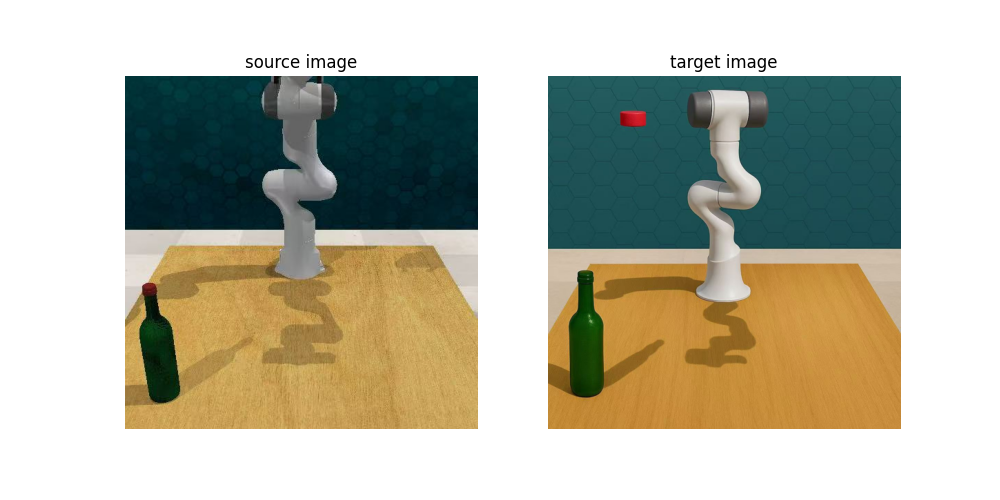

In [ ]:
img1_path = 'bottle_data/1.png' # path to the source image
img1 = Image.open(img1_path).convert('RGB') #resize(Image.open(img1_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)
img_size = img1.size

img2_path = 'bottle_data/2.png' # path to the target image
img2 = Image.open(img2_path).convert('RGB').resize(img_size) #resize(Image.open(img2_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

seg1_path = 'bottle_data/1_mask.png'
seg1 = np.array(Image.open(seg1_path).convert('L').resize(img_size))

seg2_path = 'bottle_data/2_mask.png'
seg2 = np.array(Image.open(seg2_path).convert('L').resize(img_size))

# visualize the two images in the same row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for a in ax: a.axis('off')
ax[0].imshow(img1)
ax[0].set_title('source image')
ax[1].imshow(img2)
ax[1].set_title('target image')
plt.show()

feat1 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img1)
feat2 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img2)

(512, 512)
512 512


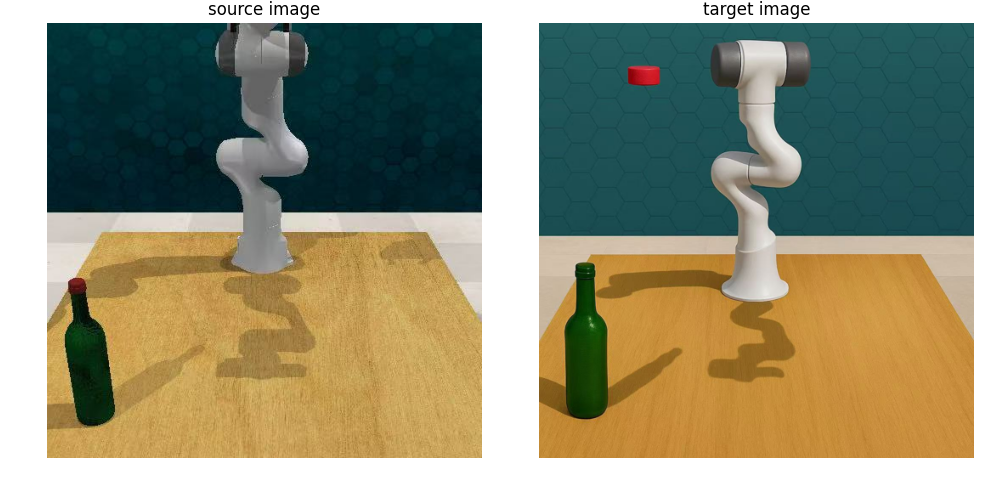

In [ ]:
from utils.utils_visualization_demo import Demo

demo = Demo([img1,img2], torch.cat([feat1, feat2], dim=0), img_size)
print(img1.size)
demo.plot_img_pairs(fig_size=5, seg=seg2)